# Sequence processing results
This notebook contains the sequence processing results of the models trained on the data from experiment 2.

In [1]:
from thesis_project.evaluation.permutation_test import run_permutation_test
from matplotlib import pyplot as plt
import seaborn as sns
from thesis_project.settings import FIGURE_DIR
from thesis_project.settings import RESULT_DIR
from thesis_project.data_loading import unpickle_object
from thesis_project.data_loading import pickle_object
import pandas as pd

from thesis_project.evaluation.result_loading import get_best_values
from thesis_project.training.best_model_retraining import INPUT_DIR, OUTPUT_DIR
from thesis_project.preprocessing.tokenization import SingleWordTokenizer
from thesis_project.settings import RESULT_DIR, EXPERIMENT2_DIR

import torch
from thesis_project.data_loading import decode_binning_params, load_train_test_ids
from thesis_project.evaluation.model_inference import ModelInference
from thesis_project.evaluation.result_loading import (
    get_best_parameter_dict,
    unify_results,
)
from thesis_project.preprocessing.label_preparation import (
    get_label_dict,
    prepare_spikerates_for_session,
)

/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-06 01:19:15.657811: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 01:19:15.669633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749165555.684472   11228 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749165555.688925   1122

## Result table

In [2]:
latex_df = {"output_type": [], "model_name": [], "HPS": [], "retraining": []}
metric_name = "loss"

rnn_results = pd.read_csv(f"{OUTPUT_DIR}/rnn_seq_clf/results.csv")
trf_results = pd.read_csv(f"{OUTPUT_DIR}/trf_seq_reg/results.csv")

results = {"rnn": rnn_results, "trf": trf_results}

for output_type in ["train", "test"]:
    for model_name in ["rnn", "trf"]:
        latex_df["output_type"].append(output_type)
        latex_df["model_name"].append(model_name)
        latex_df["retraining"].append(results[model_name][f"{output_type}_{metric_name}"].item())


        limit_to_number = 20
        model_results = get_best_values(
            f"{model_name}_seq_clf",
            input_dir=INPUT_DIR,
            limit_to_number=limit_to_number,
            label_names=["sentences"],
            metric_name=f"mean_{output_type}_loss",
            ascending=True,
        )

        latex_df["HPS"].append(model_results[f"sentences_mean_{output_type}_{metric_name}"].item())

In [3]:
pd.DataFrame(latex_df)

,output_type,model_name,HPS,retraining
0,train,rnn,0.092320,3.334274
1,train,trf,0.213286,0.213662
2,test,rnn,2.148799,2.913626
3,test,trf,1.915237,0.225358


In [4]:
print(pd.DataFrame(latex_df).to_latex(index=False,
            formatters={"name": str.upper},
            float_format="{:.2f}".format))

\begin{tabular}{llrr}
\toprule
output_type & model_name & HPS & retraining \\
\midrule
train & rnn & 0.09 & 3.33 \\
train & trf & 0.21 & 0.21 \\
test & rnn & 2.15 & 2.91 \\
test & trf & 1.92 & 0.23 \\
\bottomrule
\end{tabular}



## Permutation tests

In [12]:
def plot_permutation_test_result(
    permuted_metrics,
    actual_metrics,
    model_name_label,
    input_type,
    metric_name="perplexity",
    alpha = 0.0125,
    savefig=False,
    
):
    plt.rcParams.update({"font.size": 18})

    data = [entry[input_type][metric_name].item() for entry in permuted_metrics]
    actual_metric = actual_metrics[input_type][metric_name].item()
    p_value = len([entry for entry in sorted(data) if actual_metric >= entry]) / len(data)

    # casting to int rounds down -> conservative estimate of alpha percentile
    alpha_index = int(len(data) * alpha)
    print(f"Number of data points: {len(data)}")
    print(f"Value has to be less than {sorted(data)[alpha_index]} for alpha={alpha}")
    print(f"The p-value is {p_value}")

    sns.histplot(data=data)

    plt.title(f"{model_name_label} ({input_type})")
    plt.axvline(sorted(data)[alpha_index], label="alpha", color="red")
    plt.axvline(actual_metric, label="p-value", color="orange"
    )
    plt.legend()

    plt.xlabel("Perplexity")

    plt.tight_layout()
    if savefig:
        plt.savefig(f"{FIGURE_DIR}/{model_name}_seq_{input_type}_{metric_name}_perm_test.svg")
    plt.show()

### RNN

In [15]:
n = 1000
output_path = f"{RESULT_DIR}/final_results/retrained_models/rnn_seq_clf/permutation_test_{n}n.pkl"
output_path = f"{RESULT_DIR}/final_results/retrained_models/rnn_seq_clf/permutation_test_{n}n.pkl"
# permuted_metrics, actual_metrics = run_permutation_test("rnn", "seq_clf", n)
# pickle_object(permuted_metrics, output_path)

_, actual_metrics = run_permutation_test("rnn", "seq_clf", 0)
permuted_metrics = unpickle_object(output_path)

/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.gru(
0it [00:00, ?it/s]


In [18]:
actual_metrics

{'train': {'perplexity': tensor(5.6263, dtype=torch.float64)},
 'test': {'perplexity': tensor(10.2200, dtype=torch.float64)}}

Number of data points: 1000
Value has to be less than 5.138267470062992 for alpha=0.0125
The p-value is 0.568


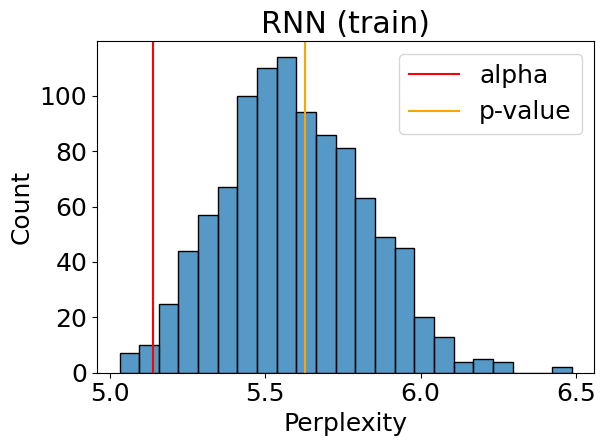

In [16]:
plot_permutation_test_result(
    permuted_metrics,
    actual_metrics,
    "RNN",
    "train",
    savefig=True
)

Number of data points: 1000
Value has to be less than 8.921754573399332 for alpha=0.0125
The p-value is 0.571


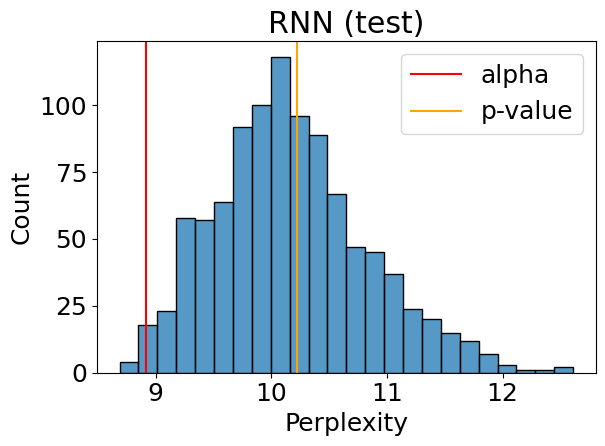

In [17]:
plot_permutation_test_result(
    permuted_metrics,
    actual_metrics,
    "RNN",
    "test",
    savefig=True
)

### Transformer

In [8]:
n = 1000
output_path = f"{RESULT_DIR}/final_results/retrained_models/trf_seq_clf/permutation_test_{n}n_ignore_index.pkl"
#output_path = f"{RESULT_DIR}/final_results/retrained_models/trf_seq_clf/permutation_test_{n}n.pkl.bkp"
#output_path = f"{RESULT_DIR}/final_results/retrained_models/trf_seq_clf/permutation_test_{n}n_og.pkl"


# permuted_metrics, actual_metrics = run_permutation_test("trf", "seq_clf", n)
# pickle_object(permuted_metrics, output_path)

_, actual_metrics = run_permutation_test("trf", "seq_clf", 0)
permuted_metrics = unpickle_object(output_path)

/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
0it [00:00, ?it/s]


In [11]:
actual_metrics

{'train': {'perplexity': tensor(18.0277, dtype=torch.float64)},
 'test': {'perplexity': tensor(33.4941, dtype=torch.float64)}}

Number of data points: 1000
Value has to be less than 23.32865879728188 for alpha=0.0125
The p-value is 0.0


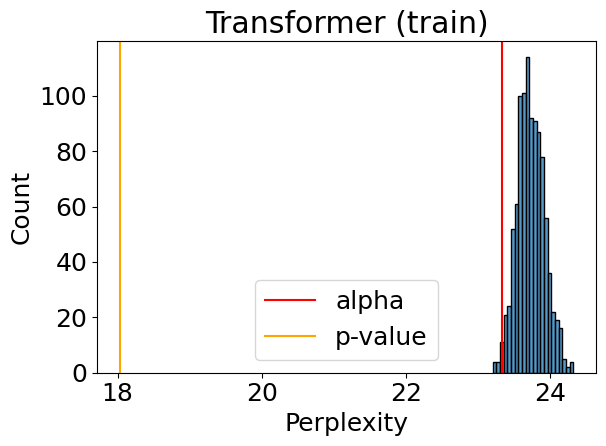

In [13]:
plot_permutation_test_result(
    permuted_metrics,
    actual_metrics,
    "Transformer",
    "train",
    savefig=True
)

Number of data points: 1000
Value has to be less than 34.273387747620745 for alpha=0.0125
The p-value is 0.0


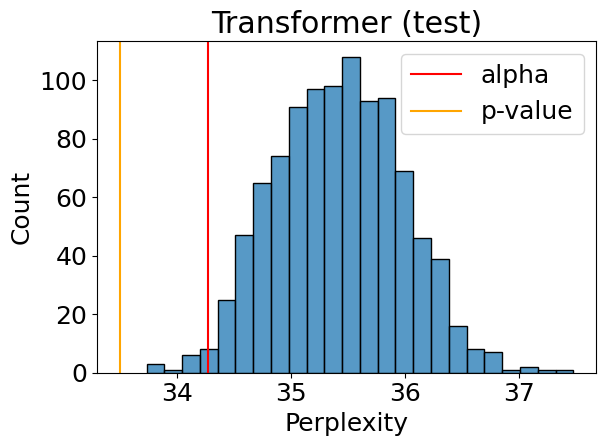

In [14]:
plot_permutation_test_result(
    permuted_metrics,
    actual_metrics,
    "Transformer",
    "test",
    savefig=True
)

## Decoded sentences

In [12]:
RANDOM_SEED = 9649737847222057372

In [13]:
tokenizer = SingleWordTokenizer()
tokenizer_file_path = f"{EXPERIMENT2_DIR}/single_word_token_dict.json"
tokenizer.token_dict_from_file(tokenizer_file_path)

In [31]:
session_id = "20240708"
experiment_name = "experiment2"
label_name = "sentences"
task_type="seq_clf"

data_split = load_train_test_ids(experiment_name)[session_id]  # [label_name]
labels = get_label_dict(session_id, experiment_name, task_type)[label_name][
    0
].cuda()
train_idx, test_idx = data_split["train_ids"], data_split["test_ids"]



def process_dataset_with_retrained_seq_clf(
    model_type,
    labels=labels,
    embedding_dim=1346,
    path=None,
    random_seed=None,
    train_labels=None,
    test_labels=None
):
    
    if random_seed:
        torch.manual_seed(random_seed)

    result_dict = unify_results(
        INPUT_DIR,
        label_names=["sentences"],
        dir_prefix=f"{model_type}_{task_type}",
        limit_to_number=10,
    )
    df_best_dict = get_best_parameter_dict(
        result_dict, quality_metric="mean_test_loss", ascending=True
    )

    # extract best parameters

    current_params = df_best_dict[label_name]
    current_params = current_params.loc[
        current_params["session_id"] == int(session_id)
    ]  #

    binning_params_string = current_params["binning_params"].values[0]
    binning_params = decode_binning_params(binning_params_string)

    spikerates_path = f"{EXPERIMENT2_DIR}/binned_spikerates"

    spikerates = prepare_spikerates_for_session(
        session_id=session_id,
        path=spikerates_path,
        bin_size=binning_params["bin_size"],
        blur_sd=binning_params["blur_sd"],
        experiment=experiment_name,
    )
    if train_labels is None:
        train_labels = labels[train_idx]
    if test_labels is None:
        test_labels = labels[test_idx]

    model_inference = ModelInference(model_type, task_type, session_id, label_name, path=path)

    train_results = model_inference.chunked_inference(
        spikerates[train_idx], train_labels, embedding_dim=embedding_dim
    )
    test_results = model_inference.chunked_inference(
        spikerates[test_idx], test_labels, embedding_dim=embedding_dim
    )

    return train_results, test_results

In [15]:
def print_decoded_sentences(result_logits, labels):
    
    for i, (result, expected) in enumerate(zip(result_logits.argmax(-1), labels)):
        cleaned_result = [r for r in result if r not in [0, 1, 2]]
        cleaned_result = tokenizer.decode([cleaned_result])[0]
        try:
            print(i, " ".join(cleaned_result))
        except Exception as e:
            print(e)


        cleaned_expected = [r for r in tokenizer.decode([expected.tolist()])[0] if r not in ["<start>", "<end>", "<pad>"]]
        
        print(i, " ".join(cleaned_expected))
        print()

### RNN (100 epochs)

In [18]:
train_results, test_results = process_dataset_with_retrained_seq_clf("rnn", random_seed=RANDOM_SEED)

/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.gru(


In [ ]:
print_decoded_sentences(train_results, labels[train_idx])

die nashörner in der
sumatra nashörner sind extrem selten

die sich
tierschützer freuen sich darüber

die nashörner die sie
sumatra nashörner sind kleiner als andere nashörner und sie haben viele haare

die können der
sie leben in asien

die sylt elbphilharmonie welt es auf der nashörner
auf der ganzen welt gibt es nur noch 80 sumatra nashörner

die von ist viel geld
darum freuen sich tierschützer sehr über das neugeborene nashornbaby

die es auf der
gibt es noch sehr viele sumatra nashörner in asien?

die ist die alten land
anders als im zoo leben die tiere dort frei

die die es auf der nashörner
früher gab es in asien viele sumatra nashörner

die ist die viele menschen sie beatles
aber jäger haben viele nashörner getötet und menschen haben den lebensraum der nashörner zerstört

sie können können
deswegen sind sie heute so selten

die ist ist nashörner
werden die sumatra nashörner geschützt?

sie können der montag
mehr sicherheit am hamburger flughafen

die ist in der
am flughafen in 

In [ ]:
print_decoded_sentences(test_results, labels[test_idx])

die
seltenes nashorn in indonesien geboren

die der
in indonesien wurde jetzt ein sumatra nashorn geboren

sie bedeutet, die
das nashornbaby ist ein sumatra nashorn

die auf sylt einen strand?
es wurde in einem nationalpark in dem land indonesien geboren

die der elbphilharmonie ist
in einem nationalpark wird die natur ganz besonders geschützt

die gebiet nashörner
dieses jahr wurde in dem nationalpark schon mal ein sumatra nashornbaby geboren

und montag
am 4 november war nämlich eine schlimme tat

die die ist die die ist
und der geiselnehmer fordert oft bestimmte dinge

das bedeutet, auf besondere
gab es eine geiselnahme am flughafen?

die ist menschen mit
und diese menschen hatten kein gutes leben

die ist der beatles viel der
einige von den menschen hatten ein sehr gutes leben in den usa

die ist die ist mit dem der
das bedeutet, die menschen haben in einem anderen land gewohnt

die ist die
auch die schulbusse fahren nicht

die ist von
auch michael kretschmer ist zu der demonstrati

### RNN (20 epochs)

In [ ]:
model_path = f"{RESULT_DIR}/final_results/retrained_models/rnn_seq_clf/model_20240708_sentences_20epochs.pkl"
train_results, test_results = process_dataset_with_retrained_seq_clf("rnn", path=model_path, random_seed=RANDOM_SEED)

/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.gru(


In [ ]:
print_decoded_sentences(train_results, labels[train_idx])

diese feucht aus jähriger risiko autozug 'wird nachmittag
sumatra nashörner sind extrem selten

das aufgenommen zutaten, minus smiley gibt gekommen politik,
tierschützer freuen sich darüber

diese bauen, ins das ausgewandert eine impfen dieses die aufgenommen rad nashörner nur überschwemmung
sumatra nashörner sind kleiner als andere nashörner und sie haben viele haare

diese aufgenommen mehr deutschland kälte lange? schützen sterben
sie leben in asien

das das hat einfache becken warum meistens katzen an, besichtigen rettungswagen längste das gut
auf der ganzen welt gibt es nur noch 80 sumatra nashörner

diese einer flugzeuge geschichten gebiet sachen 2030 schiff damm darum man
darum freuen sich tierschützer sehr über das neugeborene nashornbaby

diese paar bereits an, verglichen bäcker instagram grad deutschland 91 bauern
gibt es noch sehr viele sumatra nashörner in asien?

diese günstigsten neue lassen dürfen das artensterben? bausteine behandeln politik, man
anders als im zoo leben 

In [ ]:
print_decoded_sentences(test_results, labels[test_idx])

diese was orten, deutschland artensterben? verkehrsminister kriminelle
seltenes nashorn in indonesien geboren

diese deutschland eingespielt? natur, tierpark nashorn richtung richtung auswandererhaus wurde natur,
in indonesien wurde jetzt ein sumatra nashorn geboren

diese obstanbaugebiet morgen? john nashorn 257 güterzüge ministerpräsident kleinen
das nashornbaby ist ein sumatra nashorn

diese gefährlich land fahren jede zeit sterben gebracht häuser kindern weniger geöffnet flugzeug skandinavien
es wurde in einem nationalpark in dem land indonesien geboren

diese deutschland kälte mittwoch 96 bauern andere man stelle findet
in einem nationalpark wird die natur ganz besonders geschützt

diese theater? menschen kirschen, dann, richtung vom erfurt, klappt tage günstig? darum stechen geschichten
dieses jahr wurde in dem nationalpark schon mal ein sumatra nashornbaby geboren

diese dann eingeführt? sieg rot 2,5 bildungsorte traktoren? 2030 man gutes
am 4 november war nämlich eine schlimme 

### Transformer (100 epochs)

In [ ]:
train_results, test_results = process_dataset_with_retrained_seq_clf("trf", random_seed=RANDOM_SEED)

/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
print_decoded_sentences(train_results, labels[train_idx])

0 sumatra nashörner sind extrem selten
0 sumatra nashörner sind extrem selten

1 wollen freuen sich darüber
1 tierschützer freuen sich darüber

2 sumatra nashörner sind kleiner als andere nashörner und sie haben viele haare
2 sumatra nashörner sind kleiner als andere nashörner und sie haben viele haare

3 sie leben in asien
3 sie leben in asien

4 auf der ganzen welt gibt es nur noch 80 sumatra nashörner
4 auf der ganzen welt gibt es nur noch 80 sumatra nashörner

5 darum freuen sich tierschützer sehr über das neugeborene nashornbaby
5 darum freuen sich tierschützer sehr über das neugeborene nashornbaby

6 gibt es noch sehr viele sumatra nashörner in asien?
6 gibt es noch sehr viele sumatra nashörner in asien?

7 diese als im zoo leben die tiere dort frei
7 anders als im zoo leben die tiere dort frei

8 früher gab es in asien viele sumatra nashörner
8 früher gab es in asien viele sumatra nashörner

9 aber jäger haben viele nashörner getötet und menschen haben den lebensraum der nashörn

In [ ]:
print_decoded_sentences(test_results, labels[test_idx])

0 diese die das den zum
0 seltenes nashorn in indonesien geboren

1 in der werden schnell bauen bestimmter nashörner jedem tiere
1 in indonesien wurde jetzt ein sumatra nashorn geboren

2 der bedeutet, ist anderes die
2 das nashornbaby ist ein sumatra nashorn

3 zum ist der flughafen von der zug und
3 es wurde in einem nationalpark in dem land indonesien geboren

4 auf der flughafen so flughafen werden norddeutschland ist ausstellung
4 in einem nationalpark wird die natur ganz besonders geschützt

5 diese hat 2007 ein thüringen geld die sich sich anderes nashörner von in
5 dieses jahr wurde in dem nationalpark schon mal ein sumatra nashornbaby geboren

6 es montag mehr geiselnahme dinge
6 am 4 november war nämlich eine schlimme tat

7 deshalb es elbphilharmonie sehr sehr sehr in
7 und der geiselnehmer fordert oft bestimmte dinge

8 dabei es auf krankheit flughafen im
8 gab es eine geiselnahme am flughafen?

9 sie sie stelle sind sie auto angebot in
9 und diese menschen hatten kein gute

### Transformer (20 epochs)

In [41]:
model_path = f"{RESULT_DIR}/final_results/retrained_models/trf_seq_clf/model_20240708_sentences_ignore_index.pkl.bkp"
train_results, test_results = process_dataset_with_retrained_seq_clf("trf", path=model_path, random_seed=RANDOM_SEED)

/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
print_decoded_sentences(train_results, labels[train_idx])

die in
sumatra nashörner sind extrem selten

die die die
tierschützer freuen sich darüber

die in und die können
sumatra nashörner sind kleiner als andere nashörner und sie haben viele haare

die können in deutschland
sie leben in asien

die der es den
auf der ganzen welt gibt es nur noch 80 sumatra nashörner

die viele die
darum freuen sich tierschützer sehr über das neugeborene nashornbaby

das es auf deutschland
gibt es noch sehr viele sumatra nashörner in asien?

die die die die bauern
anders als im zoo leben die tiere dort frei

die die in der in
früher gab es in asien viele sumatra nashörner

die sie die menschen die sie die menschen elbphilharmonie
aber jäger haben viele nashörner getötet und menschen haben den lebensraum der nashörner zerstört

die sie in in
deswegen sind sie heute so selten

die bauern es
werden die sumatra nashörner geschützt?

die in
mehr sicherheit am hamburger flughafen

die der
am flughafen in hamburg werden viele neue dinge gebaut

die beispiel in
zum be

In [ ]:
print_decoded_sentences(test_results, labels[test_idx])

die die deutschland
seltenes nashorn in indonesien geboren

die der ist sänger es
in indonesien wurde jetzt ein sumatra nashorn geboren

die bedeutet, die ein mehr in
das nashornbaby ist ein sumatra nashorn

die gibt ist der der
es wurde in einem nationalpark in dem land indonesien geboren

die der menschen
in einem nationalpark wird die natur ganz besonders geschützt

die die in die der sänger in
dieses jahr wurde in dem nationalpark schon mal ein sumatra nashornbaby geboren

die
am 4 november war nämlich eine schlimme tat

die die smiley
und der geiselnehmer fordert oft bestimmte dinge

die die gibt
gab es eine geiselnahme am flughafen?

die die
und diese menschen hatten kein gutes leben

die und der beatles mehr der
einige von den menschen hatten ein sehr gutes leben in den usa

die bedeutet, die bauern ist der
das bedeutet, die menschen haben in einem anderen land gewohnt

die ist bauern
auch die schulbusse fahren nicht

die in ist die elbphilharmonie
auch michael kretschmer ist zu

### Transformer (100 epochs) - multiple inference runs

In [ ]:
train_result_list, test_result_list = [], []
random_seeds = [
    9649737847222057372,
    9947795783669641817,
    1596474062674379619,
    11671480032549764199,
    5223412656844734460,
    11802879654719421603,
    6586604105537956344,
    17581456913474303439,
    3444300933259248678,
    476678561373523806,
]

for i, random_seed in enumerate(random_seeds):
    train_results, test_results = process_dataset_with_retrained_seq_clf(
        "trf", random_seed=random_seed
    )
    train_result_list.append(train_results)
    test_result_list.append(test_results)

/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/michaela/Uni/refactoring_gitlab/th

In [ ]:
for dataset_idx in range(len(train_result_list[0])):
    print(dataset_idx)
    expected = labels[train_idx][dataset_idx]
    cleaned_expected = [r for r in tokenizer.decode([expected.tolist()])[0] if r not in ["<start>", "<end>", "<pad>"]]
    print("Expected: " + " ".join(cleaned_expected))

    for decoded_dataset in train_result_list:
        result = decoded_dataset[dataset_idx]
        cleaned_result = [r for r in result.argmax(-1) if r not in [0, 1, 2]]
        print(" ".join(tokenizer.decode([cleaned_result])[0]))

        
    print()

0
Expected: sumatra nashörner sind extrem selten
sumatra nashörner sind extrem selten
sumatra nashörner sind extrem selten
sumatra nashörner sind extrem selten
sumatra nashörner sind extrem selten
sumatra nashörner sind extrem selten
sumatra nashörner sind extrem selten
sumatra nashörner sind extrem selten
sumatra nashörner sind extrem selten
sumatra nashörner sind extrem selten
sumatra nashörner sind extrem selten

1
Expected: tierschützer freuen sich darüber
wollen freuen sich darüber
dort freuen sich darüber
wollen freuen sich darüber
tierschützer freuen sich darüber
tierschützer freuen sich darüber
tierschützer freuen sich darüber
tierschützer freuen sich darüber
dort freuen sich darüber
besteht freuen sich darüber
dort freuen sich darüber

2
Expected: sumatra nashörner sind kleiner als andere nashörner und sie haben viele haare
sumatra nashörner sind kleiner als andere nashörner und sie haben viele haare
sumatra nashörner sind kleiner als andere nashörner und sie haben viele haare

In [ ]:
for dataset_idx in range(len(test_result_list[0])):
    print(dataset_idx)
    expected = labels[test_idx][dataset_idx]
    cleaned_expected = [r for r in tokenizer.decode([expected.tolist()])[0] if r not in ["<start>", "<end>", "<pad>"]]
    print("Expected: " + " ".join(cleaned_expected))
    print()

    for decoded_dataset in test_result_list:
        result = decoded_dataset[dataset_idx]
        cleaned_result = [r for r in result.argmax(-1) if r not in [0, 1, 2]]
        print(" ".join(tokenizer.decode([cleaned_result])[0]))

        
    print()

0
Expected: seltenes nashorn in indonesien geboren

diese die das den zum
viele die hat deutschland zum
diese die hat den zum
diese die das deutschland sich
viele die das den sich
diese die hat thüringen zum dinge
nicht gesagt, hat deutschland zum dinge
diese die hat deutschland zum
diese die hat der zum dinge
viele die hat den zum

1
Expected: in indonesien wurde jetzt ein sumatra nashorn geboren

in der werden schnell bauen bestimmter nashörner jedem tiere
war einem diese schnell bauen bestimmter nashörner jedem
in der sind bauen bestimmter nashörner zeit sind
im der bisher war gerichte anderes nashörner gesagt, sind
haben einem sind war bauen bestimmter nashörner gespeichert sind
in einem werden war verkehrsprobleme großes nashörner kalt dinge
in der sind schnell verkehrsprobleme bestimmter nashörner einer ist
in der diese schnell bauen bestimmter nashörner jedem tiere
in der sind war sachsen museum nashörner die ist
haben einem ist schnell ist bestimmter nashörner malen ist

2
Expe

In [ ]:
len(train_results)

520

### Transformer (100 epochs) - decode shuffled labels

In [32]:
train_labels = labels[train_idx][torch.randperm(len(train_idx))]
test_labels = labels[test_idx][torch.randperm(len(test_idx))]
train_results, test_results = process_dataset_with_retrained_seq_clf("trf", random_seed=RANDOM_SEED, train_labels=train_labels, test_labels=test_labels)

/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [33]:
print_decoded_sentences(train_results, train_labels)

0 sumatra ist jahr land diese menschen
0 es gibt im alten land viele bustouren

1 wollen kann sie wollen können einer genau,
1 dann wissen sie später bei problemen genau,

2 sumatra haben ist baguette ist sind viele nashörner
2 besteht das französische baguette aus sehr vielen zutaten?

3 sie ist sie zecke zum dem zug
3 deshalb können die firmen ihre waren nicht mit dem zug transportieren

4 auf ganzen viele es ziel nashörner
4 der adac ist ein verein

5 darum firmen zum gesagt,
5 die unesco hat entschieden,

6 gibt gibt viele taylor viele viele sumatra in montag noch viele dorthin deutschland noch
6 der bauernverband von thüringen hat gesagt, viele bauern fahren am montag ab 5 uhr nach erfurt, um dort zu demonstrieren

7 diese können am dem thüringen leben die manche die
7 sie hat gesagt, in thüringen leben jetzt wieder ungefähr 650 biber

8 früher beispiel viele in besondere ausstellung viele vielen elbphilharmonie
8 zum kulturerbe gehören städte und besondere orte auf der welt

9 ab

In [34]:
print_decoded_sentences(test_results, test_labels)

0 diese es es strand? von bauernverband nicht
0 gibt es einen welttag der bildung?

1 in dinge viele nicht beispiel in viele schöne
1 diese orte sind zum beispiel süddeutschland, österreich, osteuropa und skandinavien

2 der dem becken von sie von beispiel dann jahr bald und die zum
2 an diesem strand können sie zum beispiel einen strandkorb mieten, im meer schwimmen und surfen

3 zum stelle vom das ein geld zwölf sachsen
3 dieser teil hat nämlich mehr als 1100 fenster

4 auf einer kinos wattenmeer ins der
4 bei den wanderungen im watt müssen sie aber vorsichtig sein

5 diese mensch hat einem von von der zug einem
5 dieser fachmann kennt sich besonders gut mit dem wattenmeer aus

6 es menschen gestochen auf sehr für auf für auf nach beispiel für
6 diese zecke ist rot braun, sie ist 2,5 bis 4 mm groß und sie beißt zum beispiel rehe, hunde, katzen und menschen

7 deshalb menschen taylor beatles glauben, in lagerhaus viel in thüringen kinos
7 einige von den menschen hatten ein sehr gutes 

### Latex tables for appendix

In [ ]:
def print_decoded_sentences_for_latex(
    rnn_result_logits, trf_result_logits, labels, limit_to_number=None
):

    print("\\begin{listliketab}")
    print("\\begin{tabularx}{\linewidth}{@{}>{\\bfseries}l @{\hspace{.05em}} XR}")
    for i, (rnn_result, trf_result, expected) in enumerate(
        zip(
            rnn_result_logits[:limit_to_number].argmax(-1),
            trf_result_logits[:limit_to_number].argmax(-1),
            labels[:limit_to_number],
        )
    ):

        rnn_cleaned_result = [r for r in rnn_result if r not in [0, 1, 2]]
        rnn_cleaned_result = tokenizer.decode([rnn_cleaned_result])[0]
        trf_cleaned_result = [r for r in trf_result if r not in [0, 1, 2]]
        trf_cleaned_result = tokenizer.decode([trf_cleaned_result])[0]

        cleaned_expected = [
            r
            for r in tokenizer.decode([expected.tolist()])[0]
            if r not in ["<start>", "<end>", "<pad>"]
        ]
        print(
            f"\\texttt{{{[i]} EXP }} & \\texttt{{"
            + " ".join(cleaned_expected)
            + "}\\\\"
        )

        try:
            print(
                f"\\texttt{{{[i]} TRF }} & \\texttt{{"
                + " ".join(trf_cleaned_result)
                + "}\\\\"
            )
        except Exception as e:
            print(e)

        try:
            print(
                f"\\texttt{{{[i]} RNN }} & \\texttt{{"
                + " ".join(rnn_cleaned_result)
                + "}\\\\\\\\"
            )
        except Exception as e:
            print(e)

    print("\\end{tabularx}")
    print("\\end{listliketab}")

In [ ]:
rnn_train_results, rnn_test_results = process_dataset_with_retrained_seq_clf("rnn", random_seed=RANDOM_SEED)
trf_train_results, trf_test_results = process_dataset_with_retrained_seq_clf("trf", random_seed=RANDOM_SEED)

/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.gru(
/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
print_decoded_sentences_for_latex(rnn_train_results, trf_train_results, labels[train_idx])

\begin{listliketab}
\begin{tabularx}{\linewidth}{@{}>{\bfseries}l @{\hspace{.05em}} XR}
\texttt{[0] EXP } & \texttt{sumatra nashörner sind extrem selten}\\
\texttt{[0] TRF } & \texttt{sumatra nashörner sind extrem selten}\\
\texttt{[0] RNN } & \texttt{die nashörner}\\\\
\texttt{[1] EXP } & \texttt{tierschützer freuen sich darüber}\\
\texttt{[1] TRF } & \texttt{wollen freuen sich darüber}\\
\texttt{[1] RNN } & \texttt{die}\\\\
\texttt{[2] EXP } & \texttt{sumatra nashörner sind kleiner als andere nashörner und sie haben viele haare}\\
\texttt{[2] TRF } & \texttt{sumatra nashörner sind kleiner als andere nashörner und sie haben viele haare}\\
\texttt{[2] RNN } & \texttt{die nashörner die sie}\\\\
\texttt{[3] EXP } & \texttt{sie leben in asien}\\
\texttt{[3] TRF } & \texttt{sie leben in asien}\\
\texttt{[3] RNN } & \texttt{die können sie}\\\\
\texttt{[4] EXP } & \texttt{auf der ganzen welt gibt es nur noch 80 sumatra nashörner}\\
\texttt{[4] TRF } & \texttt{auf der ganzen welt gibt es nur 

In [ ]:
print_decoded_sentences_for_latex(rnn_test_results, trf_test_results, labels[test_idx])

\begin{listliketab}
\begin{tabularx}{\linewidth}{@{}>{\bfseries}l @{\hspace{.05em}} XR}
\texttt{[0] EXP } & \texttt{seltenes nashorn in indonesien geboren}\\
\texttt{[0] TRF } & \texttt{diese die das den zum}\\
\texttt{[0] RNN } & \texttt{die der ist}\\\\
\texttt{[1] EXP } & \texttt{in indonesien wurde jetzt ein sumatra nashorn geboren}\\
\texttt{[1] TRF } & \texttt{in der werden schnell bauen bestimmter nashörner jedem tiere}\\
\texttt{[1] RNN } & \texttt{die der}\\\\
\texttt{[2] EXP } & \texttt{das nashornbaby ist ein sumatra nashorn}\\
\texttt{[2] TRF } & \texttt{der bedeutet, ist anderes die}\\
\texttt{[2] RNN } & \texttt{sie bedeutet, die nashörner}\\\\
\texttt{[3] EXP } & \texttt{es wurde in einem nationalpark in dem land indonesien geboren}\\
\texttt{[3] TRF } & \texttt{zum ist der flughafen von der zug und}\\
\texttt{[3] RNN } & \texttt{die auf sylt der}\\\\
\texttt{[4] EXP } & \texttt{in einem nationalpark wird die natur ganz besonders geschützt}\\
\texttt{[4] TRF } & \texttt{